# Building an Image Classification Model Using Various CNN Architectures

In [11]:
import os
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if MPS is available
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

In [2]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((227, 227)), #Alexnet expects an input size of 227 x 227 x 3
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) 
])

In [3]:
# Paths to the data
train_data_path = '../../data/human-action-recognition/train'
test_data_path = '../../data/human-action-recognition/test'

In [4]:
#Apply the transforms to the train and test data
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)

In [5]:
# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [40]:
# Train Function
def train(model, optimizer, model_name = 'default', pretrained=False, num_epochs=10, patience=5):
    # Initialize the lists to store train and test loss for each epoch
    train_losses = []
    test_losses = []
    
    # Train the model
    best_loss = torch.inf
    epochs_since_best = 0

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)  # Store the train loss for this epoch
        train_accuracy = 100. * correct / total

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0


        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # For models that return auxiliary outputs
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)  # Store the test loss for this epoch
        test_accuracy = 100. * correct / total

        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Check for best accuracy and stop if not improved after five more epochs
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_since_best = 0
            torch.save(model.state_dict(), model_name + 'best_model.pth')  # Save the model
            print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
        else:
            epochs_since_best += 1
            if epochs_since_best > patience:
                print("Stopping early: no improvement after five consecutive epochs.")
                break
    return train_losses,test_losses
    

### AlexNet Architecture

In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Calculate the size of the feature map after the last pooling layer
        self.fc_input_dim = 256 * 6 * 6  # This is for input size 224x224
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.fc_input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

Changes in the architecture are as follows:


1)__Increased Depth of Convolutional Layers:__ The AlexNet model uses more layers and deeper configurations. Starting with fewer feature channels, it progressively increases the depth across its layers. This contrasts sharply with LeNet, which uses a much simpler and shallower layer structure.


2)__Use of Batch Normalization:__ Each convolutional layer in AlexNet is followed by batch normalization, which helps in stabilizing the learning process by normalizing the input layer by adjusting and scaling activations. LeNet does not include batch normalization, which makes AlexNet better suited for training on larger datasets and more complex models.


3)__Advanced Activation Functions:__ AlexNet incorporates the ReLU (Rectified Linear Unit) activation function throughout its architecture, which helps to solve the vanishing gradient problem common in networks using sigmoid or tanh functions. LeNet traditionally uses sigmoid or tanh, which are less effective at preserving gradients during deep learning training.


4)__Increased and Varied Pooling Layers:__ AlexNet includes multiple max pooling layers that perform downsampling operation more frequently compared to LeNet. This reduces the spatial size of the representation, decreases the number of parameters and computation in the network, and hence, also controls overfitting.


5)__Integration of Dropout:__ In the classifier section of AlexNet, dropout layers are introduced. Dropout is a form of regularization that helps in preventing overfitting by randomly setting a fraction of input units to 0 at each update during training time, which helps in making the model robust and less likely to rely on any one feature.


6)__Complex Classifier Structure:__ AlexNet's classifier is more complex, using three fully connected layers with dropout and ReLU activation functions between them. This is a significant escalation from LeNet’s typically one or two-layer classifiers. This complexity allows AlexNet to make more fine-grained classifications based on the richer feature hierarchies developed in the convolutional layers.


7)__Scalability to Higher Resolution Inputs:__ AlexNet is structured to handle higher resolution input images better than LeNet. The initial convolutional layer uses a larger receptive field (11x11 with a stride of 4), which is suitable for larger input images, whereas LeNet is optimized for smaller images typical of earlier datasets like MNIST.


In [9]:
# Initialize the model
model = AlexNet().to(device)
optimizer = optim.Adam(model.parameters())
train_losses,test_losses = train(model,optimizer,model_name = 'alexnet_',)

100%|█████████████████████████████████████████| 112/112 [00:15<00:00,  7.37it/s]


Epoch [1/10], Train Loss: 1.6145, Train Accuracy: 22.94%
Test Loss: 1.5936, Test Accuracy: 22.38%
Updated best model with accuracy: 22.38%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.56it/s]


Epoch [2/10], Train Loss: 1.5745, Train Accuracy: 26.50%
Test Loss: 1.5230, Test Accuracy: 34.76%
Updated best model with accuracy: 34.76%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.57it/s]


Epoch [3/10], Train Loss: 1.5827, Train Accuracy: 26.86%
Test Loss: 1.5049, Test Accuracy: 34.92%
Updated best model with accuracy: 34.92%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.55it/s]


Epoch [4/10], Train Loss: 1.4610, Train Accuracy: 36.11%
Test Loss: 1.3643, Test Accuracy: 45.71%
Updated best model with accuracy: 45.71%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.57it/s]


Epoch [5/10], Train Loss: 1.4392, Train Accuracy: 37.51%
Test Loss: 1.3426, Test Accuracy: 45.40%
Updated best model with accuracy: 45.40%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.55it/s]


Epoch [6/10], Train Loss: 1.3576, Train Accuracy: 43.61%
Test Loss: 1.3583, Test Accuracy: 47.30%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.57it/s]


Epoch [7/10], Train Loss: 1.3950, Train Accuracy: 41.54%
Test Loss: 1.3340, Test Accuracy: 43.02%
Updated best model with accuracy: 43.02%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.56it/s]


Epoch [8/10], Train Loss: 1.3523, Train Accuracy: 43.05%
Test Loss: 1.2556, Test Accuracy: 52.70%
Updated best model with accuracy: 52.70%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.57it/s]


Epoch [9/10], Train Loss: 1.2749, Train Accuracy: 47.76%
Test Loss: 1.2986, Test Accuracy: 46.35%


100%|█████████████████████████████████████████| 112/112 [00:14<00:00,  7.57it/s]


Epoch [10/10], Train Loss: 1.2321, Train Accuracy: 50.25%
Test Loss: 1.2889, Test Accuracy: 46.35%


### Plot: Epochs vs Train Loss and Test

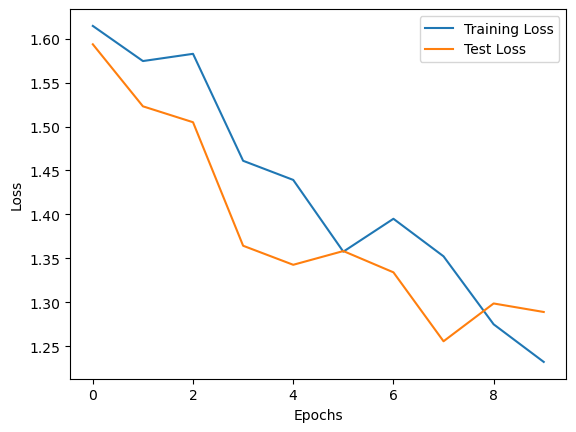

In [10]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the pre-trained DenseNet-121 model

In [26]:
# Load DenseNet121
densenet_121 = models.densenet121(pretrained=True)

# Freeze all the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Freeze all the classification layers except the last one
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 5)

# Unfreeze the last classification layer
for param in model.classifier.parameters():
    param.requires_grad = True

In [28]:
# Initialize the model
optimizer = optim.Adam(densenet_121.classifier.parameters(), lr=0.001)
model = densenet_121.to(device)
train_losses,test_losses = train(model, optimizer, model_name = 'densenet_121_', pretrained=True)

100%|█████████████████████████████████████████| 112/112 [01:17<00:00,  1.45it/s]


Epoch [1/10], Train Loss: 1.9047, Train Accuracy: 43.47%
Test Loss: 0.7050, Test Accuracy: 75.87%
Updated best model with accuracy: 75.87%


100%|█████████████████████████████████████████| 112/112 [01:14<00:00,  1.50it/s]


Epoch [2/10], Train Loss: 0.6289, Train Accuracy: 78.24%
Test Loss: 0.4269, Test Accuracy: 85.24%
Updated best model with accuracy: 85.24%


100%|█████████████████████████████████████████| 112/112 [01:15<00:00,  1.49it/s]


Epoch [3/10], Train Loss: 0.4694, Train Accuracy: 82.77%
Test Loss: 0.3566, Test Accuracy: 88.25%
Updated best model with accuracy: 88.25%


100%|█████████████████████████████████████████| 112/112 [01:15<00:00,  1.49it/s]


Epoch [4/10], Train Loss: 0.4025, Train Accuracy: 86.16%
Test Loss: 0.3268, Test Accuracy: 89.21%
Updated best model with accuracy: 89.21%


100%|█████████████████████████████████████████| 112/112 [01:15<00:00,  1.49it/s]


Epoch [5/10], Train Loss: 0.3513, Train Accuracy: 88.32%
Test Loss: 0.3131, Test Accuracy: 90.00%
Updated best model with accuracy: 90.00%


100%|█████████████████████████████████████████| 112/112 [01:15<00:00,  1.49it/s]


Epoch [6/10], Train Loss: 0.3320, Train Accuracy: 88.10%
Test Loss: 0.2902, Test Accuracy: 89.05%
Updated best model with accuracy: 89.05%


100%|█████████████████████████████████████████| 112/112 [01:16<00:00,  1.47it/s]


Epoch [7/10], Train Loss: 0.3141, Train Accuracy: 89.10%
Test Loss: 0.2742, Test Accuracy: 91.11%
Updated best model with accuracy: 91.11%


100%|█████████████████████████████████████████| 112/112 [01:16<00:00,  1.46it/s]


Epoch [8/10], Train Loss: 0.2934, Train Accuracy: 89.61%
Test Loss: 0.2674, Test Accuracy: 90.79%
Updated best model with accuracy: 90.79%


100%|█████████████████████████████████████████| 112/112 [01:16<00:00,  1.46it/s]


Epoch [9/10], Train Loss: 0.2796, Train Accuracy: 90.39%
Test Loss: 0.2715, Test Accuracy: 90.32%


100%|█████████████████████████████████████████| 112/112 [01:14<00:00,  1.50it/s]


Epoch [10/10], Train Loss: 0.2679, Train Accuracy: 90.59%
Test Loss: 0.2578, Test Accuracy: 91.59%
Updated best model with accuracy: 91.59%


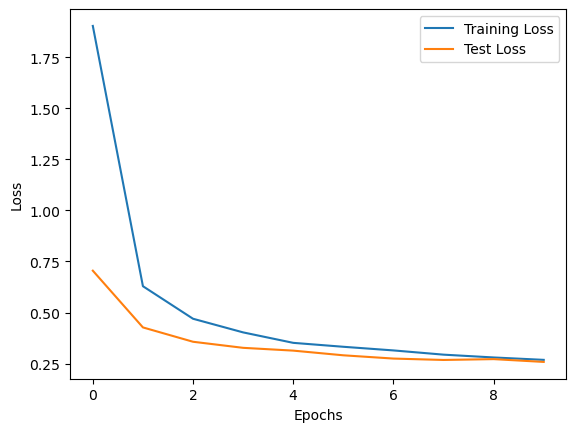

In [29]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the pre-trained EfficientNet Model.

In [30]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained EfficientNet model
efficientnet = models.efficientnet_b0(pretrained=True)

# Freeze all the feature extractor layers
for param in efficientnet.parameters():
    param.requires_grad = False

# Modify the classifier part of the model to match the number of classes (5 classes)
in_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(in_features, 5)

# Print the model architecture for verification
print(efficientnet)

/opt/anaconda3/envs/ml_dev_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/anuragkr/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:01<00:00, 11.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [31]:
# Initialize the model
optimizer = optim.Adam(efficientnet.classifier[1].parameters(), lr=0.001)
model = efficientnet.to(device)
train_losses,test_losses = train(model, optimizer, model_name = 'efficientnet_', pretrained=True)

100%|█████████████████████████████████████████| 112/112 [03:00<00:00,  1.61s/it]


Epoch [1/10], Train Loss: 0.9533, Train Accuracy: 71.51%
Test Loss: 0.5443, Test Accuracy: 85.87%
Updated best model with accuracy: 85.87%


100%|█████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]


Epoch [2/10], Train Loss: 0.5748, Train Accuracy: 82.27%
Test Loss: 0.4318, Test Accuracy: 86.83%
Updated best model with accuracy: 86.83%


100%|█████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]


Epoch [3/10], Train Loss: 0.4885, Train Accuracy: 84.12%
Test Loss: 0.3836, Test Accuracy: 89.21%
Updated best model with accuracy: 89.21%


100%|█████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]


Epoch [4/10], Train Loss: 0.4534, Train Accuracy: 84.23%
Test Loss: 0.3643, Test Accuracy: 88.73%
Updated best model with accuracy: 88.73%


100%|█████████████████████████████████████████| 112/112 [03:02<00:00,  1.63s/it]


Epoch [5/10], Train Loss: 0.4305, Train Accuracy: 85.41%
Test Loss: 0.3468, Test Accuracy: 89.37%
Updated best model with accuracy: 89.37%


100%|█████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]


Epoch [6/10], Train Loss: 0.4114, Train Accuracy: 85.80%
Test Loss: 0.3321, Test Accuracy: 89.37%
Updated best model with accuracy: 89.37%


100%|█████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]


Epoch [7/10], Train Loss: 0.3854, Train Accuracy: 86.55%
Test Loss: 0.3205, Test Accuracy: 89.68%
Updated best model with accuracy: 89.68%


100%|█████████████████████████████████████████| 112/112 [03:02<00:00,  1.63s/it]


Epoch [8/10], Train Loss: 0.3858, Train Accuracy: 86.33%
Test Loss: 0.3217, Test Accuracy: 89.21%


100%|█████████████████████████████████████████| 112/112 [03:02<00:00,  1.63s/it]


Epoch [9/10], Train Loss: 0.3708, Train Accuracy: 86.83%
Test Loss: 0.3195, Test Accuracy: 89.68%
Updated best model with accuracy: 89.68%


100%|█████████████████████████████████████████| 112/112 [03:02<00:00,  1.63s/it]


Epoch [10/10], Train Loss: 0.3530, Train Accuracy: 87.76%
Test Loss: 0.3083, Test Accuracy: 89.68%
Updated best model with accuracy: 89.68%


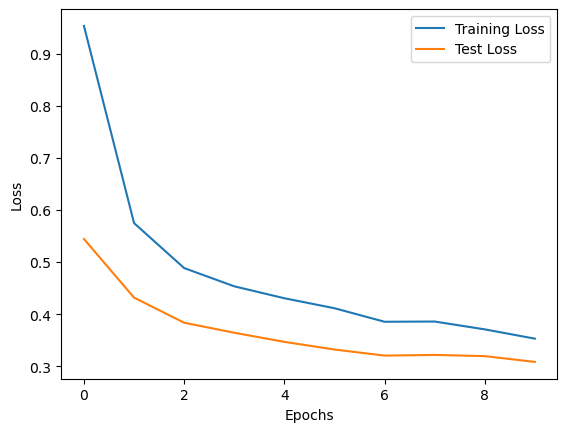

In [32]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
## Load the Pre-trained Inception v1 Model 

In [34]:
import torchvision.models as models
import torch
import torch.nn as nn

# Load the pre-trained Inception v1 (GoogLeNet) model
model = models.googlenet(pretrained=True)

# model = models.inception_v2(pretrained=True)  # Uncomment to use Inception v2
# model = models.inception_v3(pretrained=True)  # Uncomment to use Inception v3

# Freeze all the parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes (5 classes)
model.fc = nn.Linear(model.fc.in_features, 5)

print(model)

/opt/anaconda3/envs/ml_dev_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/anuragkr/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████████████████████████████████| 49.7M/49.7M [00:04<00:00, 12.1MB/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [36]:
# Initialize the model
optimizer = optim.Adam(model.fc.parameters(), lr=0.005)
model = model.to(device)
train_losses,test_losses = train(model, optimizer, model_name = 'inception_',pretrained=True, num_epochs = 5)

100%|█████████████████████████████████████████| 112/112 [01:54<00:00,  1.02s/it]


Epoch [1/5], Train Loss: 0.6640, Train Accuracy: 75.69%
Test Loss: 0.4064, Test Accuracy: 84.76%
Updated best model with accuracy: 84.76%


100%|█████████████████████████████████████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch [2/5], Train Loss: 0.4840, Train Accuracy: 82.97%
Test Loss: 0.3684, Test Accuracy: 86.51%
Updated best model with accuracy: 86.51%


100%|█████████████████████████████████████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch [3/5], Train Loss: 0.4347, Train Accuracy: 84.23%
Test Loss: 0.3035, Test Accuracy: 89.05%
Updated best model with accuracy: 89.05%


100%|█████████████████████████████████████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch [4/5], Train Loss: 0.4220, Train Accuracy: 84.73%
Test Loss: 0.3259, Test Accuracy: 87.94%


100%|█████████████████████████████████████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch [5/5], Train Loss: 0.4186, Train Accuracy: 86.11%
Test Loss: 0.3591, Test Accuracy: 87.14%


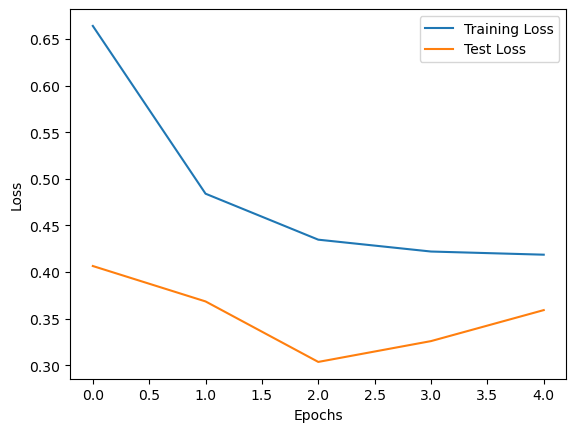

In [37]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the Pre-trained ResNet Model

In [38]:
# Load the pre-trained ResNet model
resnet = models.resnet50(pretrained=True)  # Wou can change to resnet18, resnet34, resnet101, etc. based on your requirement

# Freeze all the feature extractor layers
for param in resnet.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes (5 classes)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 5)

/opt/anaconda3/envs/ml_dev_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/anuragkr/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:12<00:00, 8.02MB/s]


In [41]:
# Initialize the model
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
model = resnet.to(device)
train_losses,test_losses = train(model, optimizer, model_name = 'resnet_', pretrained=True, num_epochs = 5)

100%|█████████████████████████████████████████| 112/112 [06:14<00:00,  3.35s/it]


Epoch [1/5], Train Loss: 0.7079, Train Accuracy: 77.68%
Test Loss: 0.3422, Test Accuracy: 90.63%
Updated best model with accuracy: 90.63%


100%|█████████████████████████████████████████| 112/112 [06:16<00:00,  3.36s/it]


Epoch [2/5], Train Loss: 0.3988, Train Accuracy: 86.81%
Test Loss: 0.2924, Test Accuracy: 90.00%
Updated best model with accuracy: 90.00%


100%|█████████████████████████████████████████| 112/112 [06:17<00:00,  3.37s/it]


Epoch [3/5], Train Loss: 0.3497, Train Accuracy: 88.04%
Test Loss: 0.2778, Test Accuracy: 90.79%
Updated best model with accuracy: 90.79%


100%|█████████████████████████████████████████| 112/112 [06:16<00:00,  3.36s/it]


Epoch [4/5], Train Loss: 0.3119, Train Accuracy: 89.30%
Test Loss: 0.2680, Test Accuracy: 91.43%
Updated best model with accuracy: 91.43%


100%|█████████████████████████████████████████| 112/112 [15:29<00:00,  8.29s/it]


Epoch [5/5], Train Loss: 0.2891, Train Accuracy: 90.08%
Test Loss: 0.2636, Test Accuracy: 91.11%
Updated best model with accuracy: 91.11%


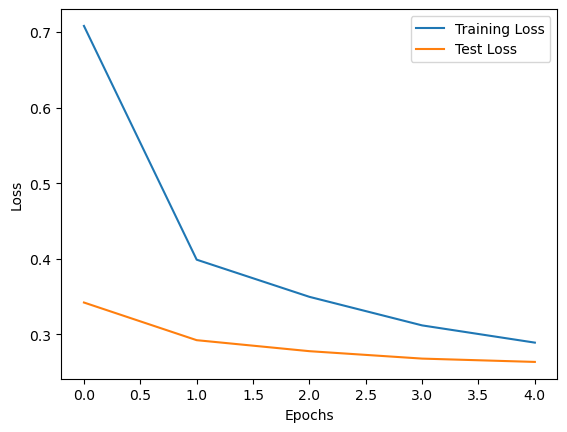

In [42]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the pre-trained VGG16 - Feature Extraction Model 

In [43]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all the feature extractor layers and the earlier classifier layers
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the classifier part of the model to match the number of classes (5 classes)
vgg16.classifier[6] = nn.Linear(4096, 5)

/opt/anaconda3/envs/ml_dev_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/anuragkr/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████| 528M/528M [02:44<00:00, 3.36MB/s]


In [44]:
# Initialize the model
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)
# Move the model to the device
model = vgg16.to(device)
train_losses,test_losses = train(model, optimizer, model_name = 'vgg_finetune_', pretrained=True)

100%|█████████████████████████████████████████| 112/112 [05:15<00:00,  2.82s/it]


Epoch [1/10], Train Loss: 0.4817, Train Accuracy: 82.32%
Test Loss: 0.2581, Test Accuracy: 90.79%
Updated best model with accuracy: 90.79%


100%|█████████████████████████████████████████| 112/112 [05:29<00:00,  2.94s/it]


Epoch [2/10], Train Loss: 0.3363, Train Accuracy: 87.68%
Test Loss: 0.2559, Test Accuracy: 92.38%
Updated best model with accuracy: 92.38%


100%|█████████████████████████████████████████| 112/112 [53:59<00:00, 28.93s/it]


Epoch [3/10], Train Loss: 0.3019, Train Accuracy: 88.29%
Test Loss: 0.2578, Test Accuracy: 91.11%


100%|█████████████████████████████████████████| 112/112 [05:15<00:00,  2.82s/it]


Epoch [4/10], Train Loss: 0.3189, Train Accuracy: 88.46%
Test Loss: 0.2452, Test Accuracy: 91.11%
Updated best model with accuracy: 91.11%


100%|█████████████████████████████████████████| 112/112 [05:16<00:00,  2.83s/it]


Epoch [5/10], Train Loss: 0.2796, Train Accuracy: 88.91%
Test Loss: 0.2404, Test Accuracy: 91.59%
Updated best model with accuracy: 91.59%


100%|█████████████████████████████████████████| 112/112 [05:16<00:00,  2.83s/it]


Epoch [6/10], Train Loss: 0.2562, Train Accuracy: 90.67%
Test Loss: 0.2645, Test Accuracy: 89.68%


100%|█████████████████████████████████████████| 112/112 [05:15<00:00,  2.82s/it]


Epoch [7/10], Train Loss: 0.2563, Train Accuracy: 90.81%
Test Loss: 0.2462, Test Accuracy: 90.48%


100%|█████████████████████████████████████████| 112/112 [05:16<00:00,  2.83s/it]


Epoch [8/10], Train Loss: 0.2538, Train Accuracy: 90.59%
Test Loss: 0.2431, Test Accuracy: 90.63%


100%|█████████████████████████████████████████| 112/112 [05:17<00:00,  2.83s/it]


Epoch [9/10], Train Loss: 0.2453, Train Accuracy: 90.84%
Test Loss: 0.2495, Test Accuracy: 91.27%


100%|█████████████████████████████████████████| 112/112 [05:22<00:00,  2.88s/it]


Epoch [10/10], Train Loss: 0.2280, Train Accuracy: 91.65%
Test Loss: 0.2598, Test Accuracy: 91.11%


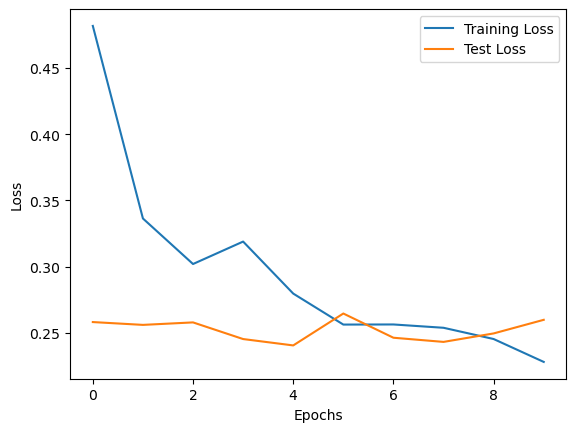

In [45]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the pre-trained VGG16 - Fine-Tuning Model 

In [46]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all the feature extractor layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier part of the model to match the number of classes (2 classes: Cat and Dog)
vgg16.classifier[6] = nn.Linear(4096, 5)

# Ensure only the last layer is trainable
for param in vgg16.classifier[6].parameters():
    param.requires_grad = True

In [47]:
# Initialize the model
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)
# Move the model to the device
model = vgg16.to(device)
train_losses,test_losses = train(model, optimizer, model_name = 'vgg_feature_extract_', pretrained=True, num_epochs=3)

100%|█████████████████████████████████████████| 112/112 [05:33<00:00,  2.98s/it]


Epoch [1/3], Train Loss: 0.7880, Train Accuracy: 78.26%
Test Loss: 0.3991, Test Accuracy: 87.62%
Updated best model with accuracy: 87.62%


100%|█████████████████████████████████████████| 112/112 [05:35<00:00,  3.00s/it]


Epoch [2/3], Train Loss: 0.4222, Train Accuracy: 90.42%
Test Loss: 0.8222, Test Accuracy: 84.76%


100%|█████████████████████████████████████████| 112/112 [05:35<00:00,  2.99s/it]


Epoch [3/3], Train Loss: 0.5729, Train Accuracy: 91.68%
Test Loss: 0.7517, Test Accuracy: 90.00%


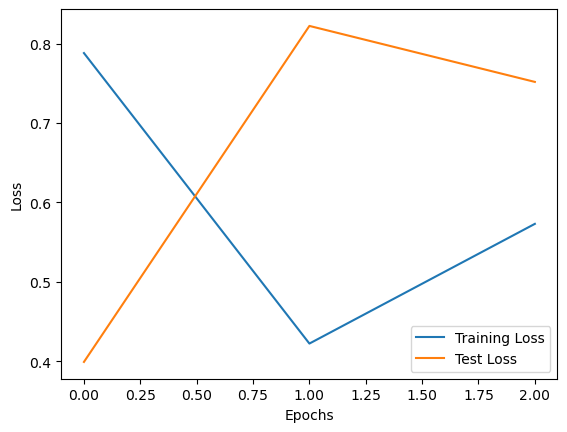

In [48]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Loading the Best Model

In [ ]:
# Load a pre-trained model
model = models.vgg16(pretrained=False)  # Make sure to set pretrained=False to load your own weights

# Modify the final layer to match your number of classes if necessary
num_classes = 5  # Example: for 5 classes
model.classifier[6] = torch.nn.Linear(4096, num_classes)

In [49]:
model_weights_path = 'vgg_finetune_best_model.pth'

# Load the weights
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
model.eval() 

/var/folders/12/h54n268d1f13rwcrx9wfckmc0000gn/T/ipykernel_2448/357270503.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

##  Define the Transforms and Import your image

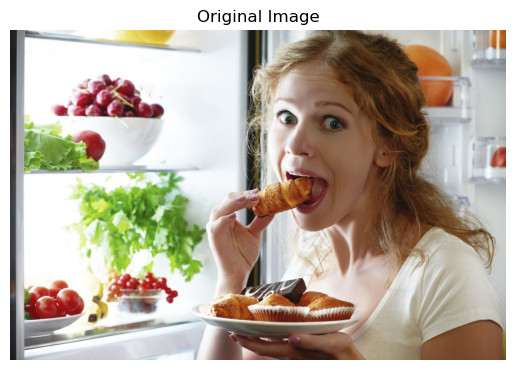

In [52]:
from PIL import Image
# Define the transformation to match the input requirements of VGG16
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = '../../data/human-action-recognition/test_img.jpg'  # Replace with the actual path to your image
image = Image.open(image_path).convert('RGB')

# Display the original image
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')  # Hide axes
plt.show()

# Apply the transformations
input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

## Make predictions using our model

In [53]:
# Make prediction
with torch.no_grad():
    output = model(input_image)
    _, predicted = torch.max(output, 1)

# Define the class labels
class_labels = {0: 'cycling', 1: 'dancing', 2: 'drinking', 3: 'eating', 4: 'sitting'}

# Print the prediction
predicted_label = class_labels[predicted.item()]
print(f"Predicted activity: {predicted_label}")

Predicted activity: eating
